<a href="https://colab.research.google.com/github/anvitendulkar10/Projects/blob/master/Airline%20Price%20Prediction/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install feature_engine


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

warnings.filterwarnings('ignore')
import plotly.express as px
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder,OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC,SVR
from sklearn import set_config
set_config(transform_output="pandas")
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,f1_score,confusion_matrix,classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from datetime import datetime, timedelta
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection, SelectBySingleFeaturePerformance, SelectByTargetMeanPerformance




In [3]:
df = pd.read_excel('/content/drive/MyDrive/Github Project/Project/Airline Fare  Prediction/Data_Train_clean.xlsx')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df.shape

(10682, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10682 entries, 0 to 10681
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.1+ KB


In [7]:
df.dropna(inplace = True)

In [8]:
df[['Airline','Source','Destination']] = df[['Airline','Source','Destination']].astype('category')

In [9]:
memory_in_bytes = df.memory_usage().sum()
memory_in_mb = memory_in_bytes / (1024 ** 2)
memory_in_mb


0.6834506988525391

##  split the data

In [10]:
X = df.drop('Price' , axis=1)
y = df['Price']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=42)

In [12]:
X_train['Airline'].value_counts()

,count
Airline,
Jet Airways,2688
IndiGo,1478
Air India,1216
Multiple carriers,832
SpiceJet,549
Vistara,331
Air Asia,223
GoAir,141
Multiple carriers Premium economy,12


In [13]:
print(X_train.shape, X_test.shape)

(7477, 10) (3205, 10)


In [14]:
# X_train_df['Duration']
# non_string_mask = ~X_train_df['Duration'].apply(lambda x: isinstance(x, str))

# # Extract non-string values
# non_string_values = X_train_df[non_string_mask]
# non_string_values

In [15]:
def arrival_date_extract(X):
  def extract(df):
    pattern = r'(?:(\d+)h)?\s?(?:(\d+)m)?'
    matchobj = re.match(pattern, df['Duration'])
    hr = int(matchobj.group(1)) if matchobj.group(1) else 0
    min = int(matchobj.group(2)) if matchobj.group(2) else 0
    journey_dt = df['Date_of_Journey']+' '+ df['Dep_Time']
    dt_time = datetime.strptime(journey_dt, "%d/%m/%Y %H:%M")
    arrival_date = dt_time + timedelta(hours=hr, minutes=min)
    day = arrival_date.day
    month = arrival_date.month
    hour = arrival_date.hour
    minute = arrival_date.minute
    return pd.Series([hr,min,day, month, hour, minute], index=['duration_hr','duration_min','arrival_day', 'arrival_month', 'arrival_hour', 'arrival_minute'])
  return X.apply(extract, axis=1)


def Date_of_Journey_split(X):
  def extract(df):
    jorney=  pd.to_datetime(df)
    month= jorney.month
    day = jorney.day
    return pd.Series({'journey_month': month, 'journey_day': day})
  return X.apply(extract)


def departure_time_split(X1):
  def extract(temp):
    hour = temp.split(':')[0]
    minute = temp.split(':')[1]
    return pd.Series([hour,minute] ,index=['dep_hour', 'dep_min'])
  return X1.apply(extract)


def total_stop(X):
  def extract(row):
    row = row.replace('non-stop', '0 stop')
    pattern = r'(\d)\s?\w+'
    matchobj = re.match(pattern, row)
    if matchobj is not None:
      return pd.Series([int(matchobj.group(1))],index=['Total_Stops'])
  return X.apply(extract)


# Feature Engineering

In [16]:
preprocessor =ColumnTransformer([
    ('arrival_date_extract', FunctionTransformer(arrival_date_extract,validate=False), ['Date_of_Journey','Dep_Time','Duration']),
    ('Date_of_Journey_split', FunctionTransformer(Date_of_Journey_split,validate=False), 'Date_of_Journey'),
    ('departure_time_split', FunctionTransformer(departure_time_split,validate=False), 'Dep_Time'),
    ('total_stop', FunctionTransformer(total_stop,validate=False), 'Total_Stops'),
    ('column_dropper', 'drop', ['Route', 'Arrival_Time', 'Additional_Info']),
  ], remainder='passthrough', verbose_feature_names_out=False,)
clf = Pipeline([
    ('preprocessor',preprocessor),
])


# Feature selection

In [17]:
import pandas as pd
from scipy.stats import chi2_contingency

# Sample data
data =  X_train[['Source','Destination','Airline']]

# Function to calculate chi-square test
def chi_square_test(data, col1, col2):
    # Create a contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])
    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

# Pairwise tests
chi2_source_dest, p_source_dest = chi_square_test(data, 'Source', 'Destination')
chi2_source_airline, p_source_airline = chi_square_test(data, 'Source', 'Airline')
chi2_dest_airline, p_dest_airline = chi_square_test(data, 'Destination', 'Airline')

print(f"Source vs Destination: chi2 = {chi2_source_dest}, p-value = {p_source_dest}")
print(f"Source vs Airline: chi2 = {chi2_source_airline}, p-value = {p_source_airline}")
print(f"Destination vs Airline: chi2 = {chi2_dest_airline}, p-value = {p_dest_airline}")

Source vs Destination: chi2 = 29908.0, p-value = 0.0
Source vs Airline: chi2 = 2363.952878809835, p-value = 0.0
Destination vs Airline: chi2 = 2528.6485996882743, p-value = 0.0


In [18]:
# sns.heatmap(X_train_df.corr(numeric_only =True), annot =True,fmt = '.1f',cmap = 'coolwarm')

In [19]:
le =LabelEncoder()
def LabelEncoding(df):
  df=df.apply(le.fit_transform)
  return df

encoder =ColumnTransformer([
    # ('one-hot', OneHotEncoder(drop='first', sparse_output=False, dtype='int16' ,handle_unknown = 'ignore'), ['Source', 'Destination']),
    ('label_encoder',FunctionTransformer(LabelEncoding),['Airline','Source', 'Destination']),
    # ('column_dropper', 'drop', ['arrival_day','arrival_month']),

], remainder='passthrough', verbose_feature_names_out=False)


en_clf = Pipeline([
    ('clf',clf),
    ('encoder',encoder),
    ('scalar',MinMaxScaler())
])

In [20]:
X_train.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
749,Jet Airways,27/06/2019,Mumbai,Hyderabad,BOM → HYD,10:20,11:50,1h 30m,non-stop,No info
6077,SpiceJet,21/06/2019,Kolkata,Banglore,CCU → BLR,17:10,19:40,2h 30m,non-stop,No info


In [21]:
X_train_df = en_clf.fit_transform(X_train)
X_train_df.head(2)

,Airline,Source,Destination,duration_hr,duration_min,arrival_day,arrival_month,arrival_hour,arrival_minute,journey_month,journey_day,dep_hour,dep_min,Total_Stops
749,0.363636,1.00,0.6,0.021277,0.545455,0.928571,1.0,0.478261,0.909091,0.454545,1.00,0.434783,0.363636,0.0
6077,0.727273,0.75,0.0,0.042553,0.545455,0.714286,1.0,0.826087,0.727273,0.454545,0.75,0.739130,0.181818,0.0


<Axes: >

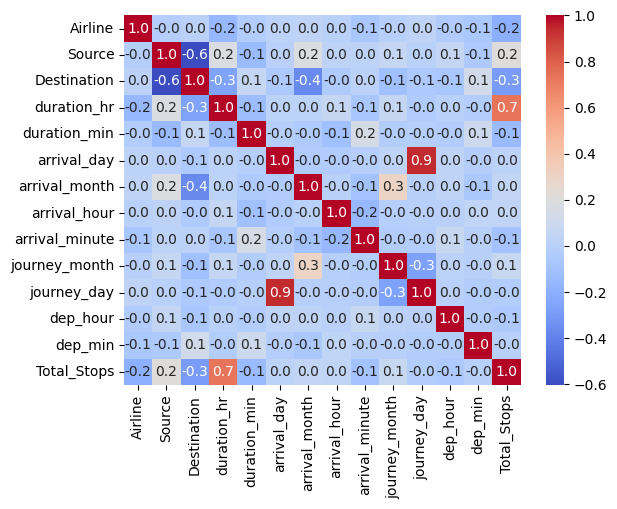

In [22]:
sns.heatmap(X_train_df.corr(), annot =True,fmt = '.1f',cmap = 'coolwarm')

In [23]:
# 1 .variance Threshold method
sel = VarianceThreshold()  # removes all low variance fatures get_support()-An index that selects the retained features from a feature vector
sel.fit(X_train_df)
X_train_df.columns[~sel.get_support()]

Index([], dtype='object')

In [24]:
# 2. find Correlated features
sel =DropCorrelatedFeatures(method="pearson" ,threshold=0.80)
sel.fit(X_train_df)
print(sel.correlated_feature_sets_)
print(f"features which can be drpped :{sel.features_to_drop_}")

[{'journey_day', 'arrival_day'}]
features which can be drpped :['journey_day']


In [25]:
rf = RandomForestRegressor(random_state =42)
rf.fit(X_train_df,y_train)
fi_2 = pd.DataFrame( {'feature' : X_train_df.columns ,'RFimportance' :rf.feature_importances_})
fi_2.sort_values('RFimportance',ascending=False)

,feature,RFimportance
3,duration_hr,0.454254
10,journey_day,0.113851
0,Airline,0.096763
13,Total_Stops,0.055845
9,journey_month,0.051005
11,dep_hour,0.037005
7,arrival_hour,0.034638
12,dep_min,0.034520
5,arrival_day,0.031331
4,duration_min,0.027503


In [26]:
rf = GradientBoostingRegressor()
rf.fit(X_train_df,y_train)
fi_3 = pd.DataFrame( {'feature' : X_train_df.columns ,'GBimportance' :rf.feature_importances_})
fi_3

,feature,GBimportance
0,Airline,0.172333
1,Source,0.004898
2,Destination,0.010780
3,duration_hr,0.507622
4,duration_min,0.002897
5,arrival_day,0.009675
6,arrival_month,0.007496
7,arrival_hour,0.012980
8,arrival_minute,0.006315
9,journey_month,0.063664


In [27]:
lasso = Lasso(alpha=0.1)  # alpha is the regularization strength
lasso.fit(X_train_df, y_train)
# Coefficients
coefficients = lasso.coef_
# Selected features
selected_features = X_train_df.columns[coefficients == 0].tolist()
selected_features

[]

In [28]:
encoded_data = en_clf.fit_transform(X_train,y_train)

In [29]:
encoded_data.head(2)

,Airline,Source,Destination,duration_hr,duration_min,arrival_day,arrival_month,arrival_hour,arrival_minute,journey_month,journey_day,dep_hour,dep_min,Total_Stops
749,0.363636,1.00,0.6,0.021277,0.545455,0.928571,1.0,0.478261,0.909091,0.454545,1.00,0.434783,0.363636,0.0
6077,0.727273,0.75,0.0,0.042553,0.545455,0.714286,1.0,0.826087,0.727273,0.454545,0.75,0.739130,0.181818,0.0


Airline
Source
Destination
duration_hr
duration_min
arrival_day
arrival_month
arrival_hour
arrival_minute
journey_month
journey_day
dep_hour
dep_min
Total_Stops


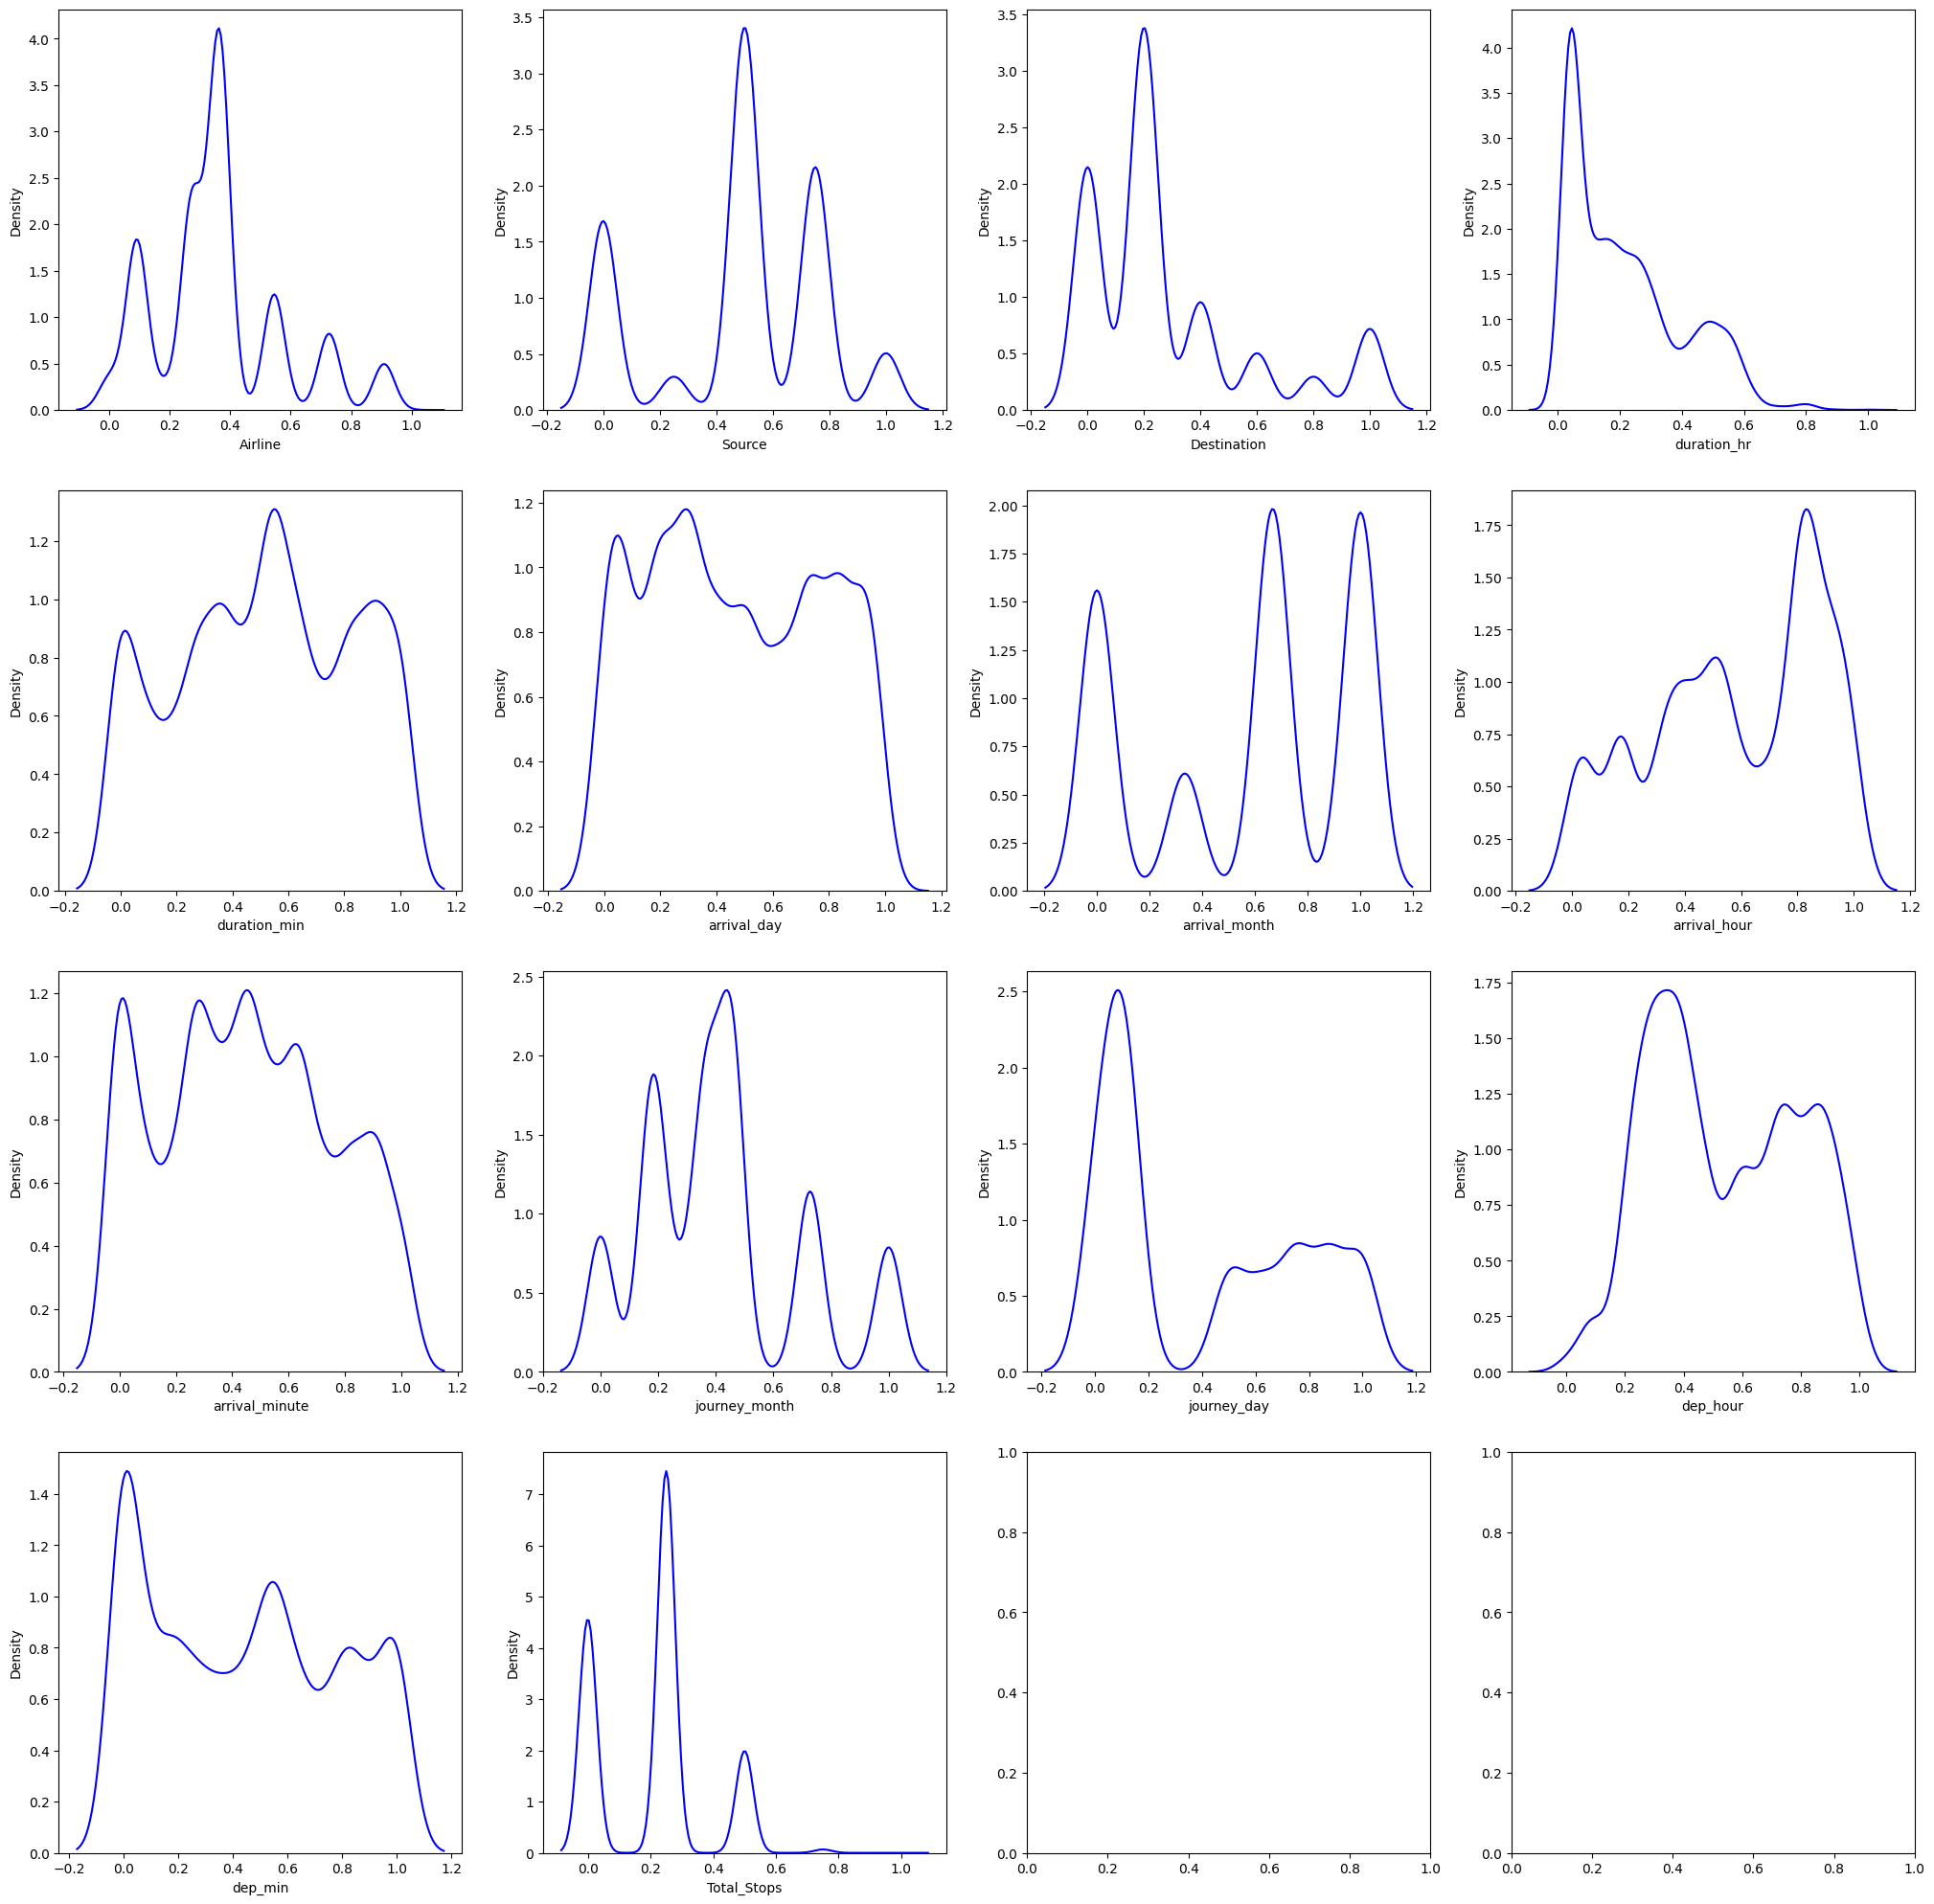

In [30]:
# here Freedman-Diaconis Rule is used to decide the bins
import math
fig,axis = plt.subplots(math.ceil(encoded_data.shape[1]/4),4,figsize=(25,25))
for col, ax in zip(encoded_data.columns, axis.ravel()):
  print(col)
  sns.kdeplot(encoded_data[col], ax=ax,color="b")
plt.show()


<Axes: xlabel='Price', ylabel='Density'>

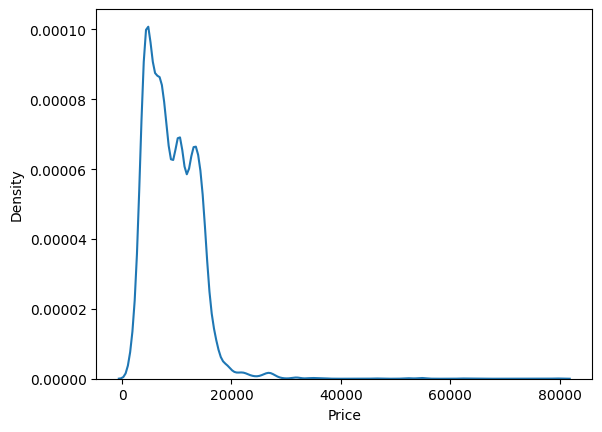

In [31]:
sns.kdeplot(y_train)

<Axes: xlabel='Price', ylabel='Density'>

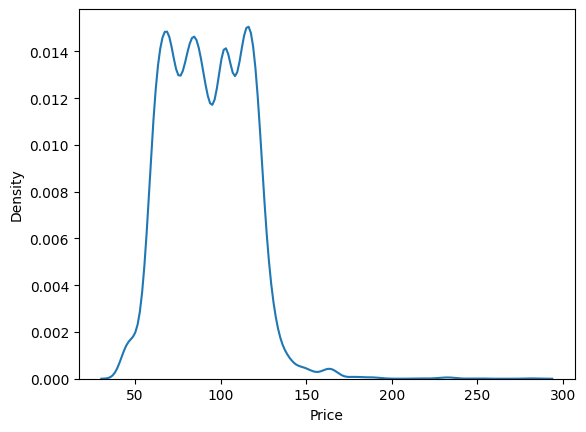

In [32]:
tt =np.sqrt(y_train)
sns.kdeplot(tt)

# model bilding

In [33]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    # 'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [34]:
def scorer(model_name, model, X_train, X_test):
    output = []

    output.append(model_name)
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model,X_train, y_train , cv=kfold, scoring='r2')
    output.append(scores.mean())
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    output.append(mean_absolute_error(y_test,y_pred))
    return output


In [35]:
X_test_encode =  en_clf.transform(X_test)

In [36]:
# model_output = []
# for model_name,model in model_dict.items():

#     model_output.append(scorer(model_name, model,encoded_data,X_test_encode))
# model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])
# model_df.sort_values(['mae'])
# model_df

# Hyperparameter Tuning

In [37]:
param_grid = {'xgb__n_estimators': [250,300,350,400,450],
    'xgb__learning_rate': [0.01,0.05, 0.1, 0.2,0.5],
    'xgb__max_depth': [4, 5,6,7,8]
              }

final_clf = Pipeline([
    ('clf',clf),
    ('encoder',encoder),
    ('scalar',MinMaxScaler()),
    ('xgb', XGBRegressor())
])
grid_search = GridSearchCV(final_clf, param_grid, cv=5, scoring='r2', verbose=4)
# grid_search.fit(X_train,y_train)


In [38]:
# best_params = grid_search.best_params_
# print(best_params)
# best_estimator = grid_search.best_estimator_
# print(best_estimator)

In [44]:
# param_grid = {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 300}
# param_grid={'learning_rate':0.05, 'max_depth':7, 'n_estimators':300}
param_grid={ 'n_estimators': 300, 'learning_rate' : 0.01, 'max_depth' : 7, 'min_child_weight' :1,
     'subsample' :0.8,'colsample_bytree' : 0.8, 'reg_alpha' : 0.5,'reg_lambda':1,
    'random_state':42}
pipeline = Pipeline([
    ('clf',clf),
    ('encoder',encoder),
    ('scalar',MinMaxScaler()),
    ('xgb', XGBRegressor(**param_grid))
])

In [45]:
pipeline.fit(X_train ,y_train)
print("training score : ",pipeline.score(X_train, y_train))
print("testing score : ",pipeline.score(X_test, y_test))
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
n = len(y_test)
p = X_test.shape[1]
adjusted_r2 = 1 - (((1 - r2) * (n - 1)) / (n - p - 1))
print(f"Adjusted R-squared: {adjusted_r2}")
# Adj_r2 = 1 - (1-r2_score(y, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)

training score :  0.8684931397438049
testing score :  0.7998378872871399
Mean Absolute Error: 1333.941238284297
R-squared: 0.7998378872871399
Adjusted R-squared: 0.7992112056568554


In [46]:
out=pd.DataFrame({'Price_actual':y_test,'Price_pred':y_pred})
result=X_test.merge(out,left_index=True,right_index=True)
result.head(10)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price_actual,Price_pred
6075,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → IDR → BOM → COK,15:05,01:30 22 May,10h 25m,2 stops,No info,16655,15566.066406
3544,GoAir,3/06/2019,Delhi,Cochin,DEL → BOM → COK,10:35,19:35,9h,1 stop,No info,4959,6759.162109
9290,Vistara,9/05/2019,Kolkata,Banglore,CCU → DEL → BLR,20:20,09:05 10 May,12h 45m,1 stop,No info,9187,9198.522461
5032,IndiGo,24/05/2019,Chennai,Kolkata,MAA → CCU,14:45,17:05,2h 20m,non-stop,No info,3858,4480.659668
2483,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,22:50,04:25 22 May,5h 35m,1 stop,In-flight meal not included,12898,12970.833984
9893,Multiple carriers,6/05/2019,Delhi,Cochin,DEL → BOM → COK,07:30,19:00,11h 30m,1 stop,No info,10529,10444.710938
346,Jet Airways,27/05/2019,Delhi,Cochin,DEL → BOM → COK,10:00,19:00,9h,1 stop,No info,16079,13023.654297
6365,Jet Airways,6/04/2019,Banglore,Delhi,BLR → DEL,11:10,14:05,2h 55m,non-stop,No info,7229,6144.391113
7624,Jet Airways,21/05/2019,Kolkata,Banglore,CCU → BOM → BLR,06:30,19:50,13h 20m,1 stop,In-flight meal not included,10844,11952.233398
3393,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,19:00,11h,1 stop,No info,16289,13051.176758


In [42]:
X_val_test = pd.read_excel('/content/drive/MyDrive/Github Project/Project/Airline Fare  Prediction/Test_set.xlsx')

In [43]:
y_val_pred = pipeline.predict(X_val_test)


After applying standard scaler
name	r2	mae
0	linear_reg	-3.394841e+20	1937.092388
1	svr	3.270034e-02	3419.661451
2	ridge	6.156141e-01	1936.176923
3	LASSO	6.156285e-01	1935.491688
4	decision tree	6.952788e-01	1338.110016
5	random forest	8.047634e-01	1160.130514
6	extra trees	7.816255e-01	1205.477298
7	gradient boosting	7.665432e-01	1480.556497
8	adaboost	3.833611e-01	2859.673779
9	xgboost	8.123507e-01	1156.111304